In [1]:
import pandas as pd
from selenium import webdriver
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import kaggle
import math

kaggle.api.authenticate()
plt.style.use('ggplot')
pd.options.display.max_columns=100

In [2]:
%%time

#kaggle.api.dataset_download_files('jordankrishnayah/45m-headlines-from-2007-2022-10-largest-sites','csv_files/',unzip=True)

df=pd.read_csv('csv_files/headlines.csv')

CPU times: total: 18.8 s
Wall time: 20.6 s


In [3]:
df=df[df['Headline'].astype(str).str.lower().str.contains('comment',regex=True)==False]

### Assign sentiment scores to headlines 

In [4]:
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
sia=SentimentIntensityAnalyzer()

from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

from nltk.corpus import stopwords
stopwords=stopwords.words('english')

In [5]:
def comment_sentiment_scores(comment):
    comment_tokenized=nltk.word_tokenize(comment)
    comment_lower=[w.lower() for w in comment_tokenized]
    comment_lemmatized=[lemmatizer.lemmatize(w) for w in comment_lower]
    comment_filtered=[w for w in comment_lemmatized if w not in stopwords]
    final_comment=' '.join(comment_filtered)
    
    score=sia.polarity_scores(final_comment)
    return score

In [ ]:
%%time

percentage_interval = int(len(df['Headline']) / 100)
progress_interval = 0

scores = []

for i,Headline in enumerate(df['Headline']):
    if isinstance(Headline, str):
        scores.append(comment_sentiment_scores(Headline))
    else:
        scores.append(None)

    if (i + 1) % percentage_interval == 0:
        progress_interval += 1
        print(f"Progress: {progress_interval}%")
        
#headline_scores=pickle.dump(scores,open('headline_scores.pickle','wb'))

In [6]:
scores=pickle.load(open('headline_scores.pickle','rb'))

In [7]:
df['Scores']=scores

In [8]:
df['Compound']=[score['compound'] if score is not None else None for score in scores]
df['Positive']=[score['pos'] if score is not None else None for score in scores]
df['Negative']=[score['neg'] if score is not None else None for score in scores]

In [9]:
%%time
df['Date']=df['Date'].apply(lambda x:str(x)[:4]+str(x)[4:6]+str(x)[6:] if x is not None else None).apply(pd.to_datetime,errors='coerce')

CPU times: total: 9min 1s
Wall time: 9min 11s


In [10]:
df

,Date,Publication,Headline,URL,Scores,Compound,Positive,Negative
0,2007-01-01,New York Times,Rush to Hang Hussein Was Questioned,http://www.nytimes.com/2007/01/01/world/middle...,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...",-0.1027,0.000,0.259
1,2007-01-01,New York Times,"News Analysis: For Sunnis, Dictators End Is O...",http://www.nytimes.com/2007/01/01/world/middle...,"{'neg': 0.324, 'neu': 0.676, 'pos': 0.0, 'comp...",-0.3400,0.000,0.324
2,2007-01-01,New York Times,Hard Choices Over Video,http://www.nytimes.com/2007/01/01/world/middle...,"{'neg': 0.412, 'neu': 0.588, 'pos': 0.0, 'comp...",-0.1027,0.000,0.412
3,2007-01-01,New York Times,States Take Lead on Ethics Rules for Lawmakers,http://www.nytimes.com/2007/01/01/us/01ethics....,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000
4,2007-01-01,New York Times,"Spitzer Arrives With Mandate, but Faces Challe...",http://www.nytimes.com/2007/01/01/nyregion/01e...,"{'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'comp...",0.0772,0.245,0.000
...,...,...,...,...,...,...,...,...
4405392,2023-01-01,The Guardian,2023 in books Highlights for the year ahead,https://www.theguardian.com/books/2022/dec/31/...,"{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...",0.3400,0.375,0.000
4405393,2023-01-01,The Guardian,The best hopeful films for a new year,https://www.theguardian.com/film/2022/dec/31/s...,"{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'comp...",0.8176,0.714,0.000
4405394,2023-01-01,The Guardian,Obituary Barbara Walters,https://www.theguardian.com/tv-and-radio/2022/...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000
4405395,2023-01-01,The Guardian,Barbara Walters,https://www.theguardian.com/tv-and-radio/2022/...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000


### Analyzing scores

In [11]:
g=df.groupby([df['Date'].dt.to_period('M'),'Publication'])['Compound'].mean().sort_index(level=[1,0])

C:\Users\berid\AppData\Local\Temp\ipykernel_6832\2328094515.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  corr=g.reset_index().pivot('Date','Publication','Compound').corr()


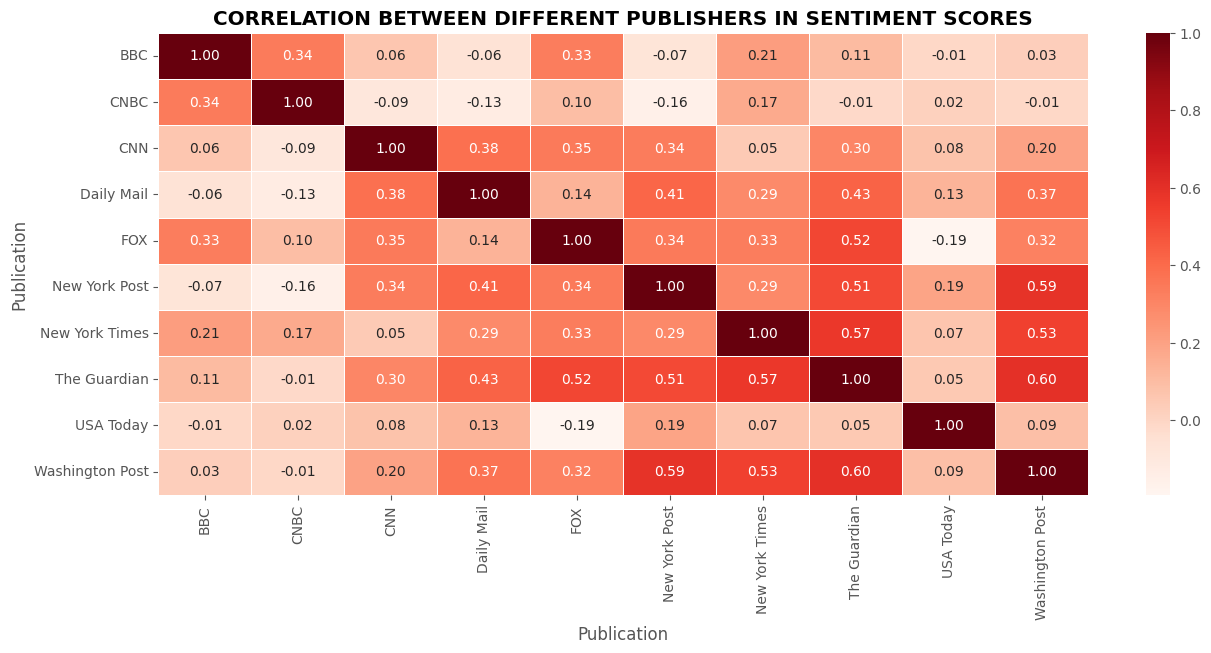

In [12]:
corr=g.reset_index().pivot('Date','Publication','Compound').corr()

plt.figure(figsize=(15,6))
sns.heatmap(corr,annot=True, cmap='Reds',fmt=".2f", linewidths=0.5)
plt.title('CORRELATION BETWEEN DIFFERENT PUBLISHERS IN SENTIMENT SCORES',fontweight='bold')
plt.show()

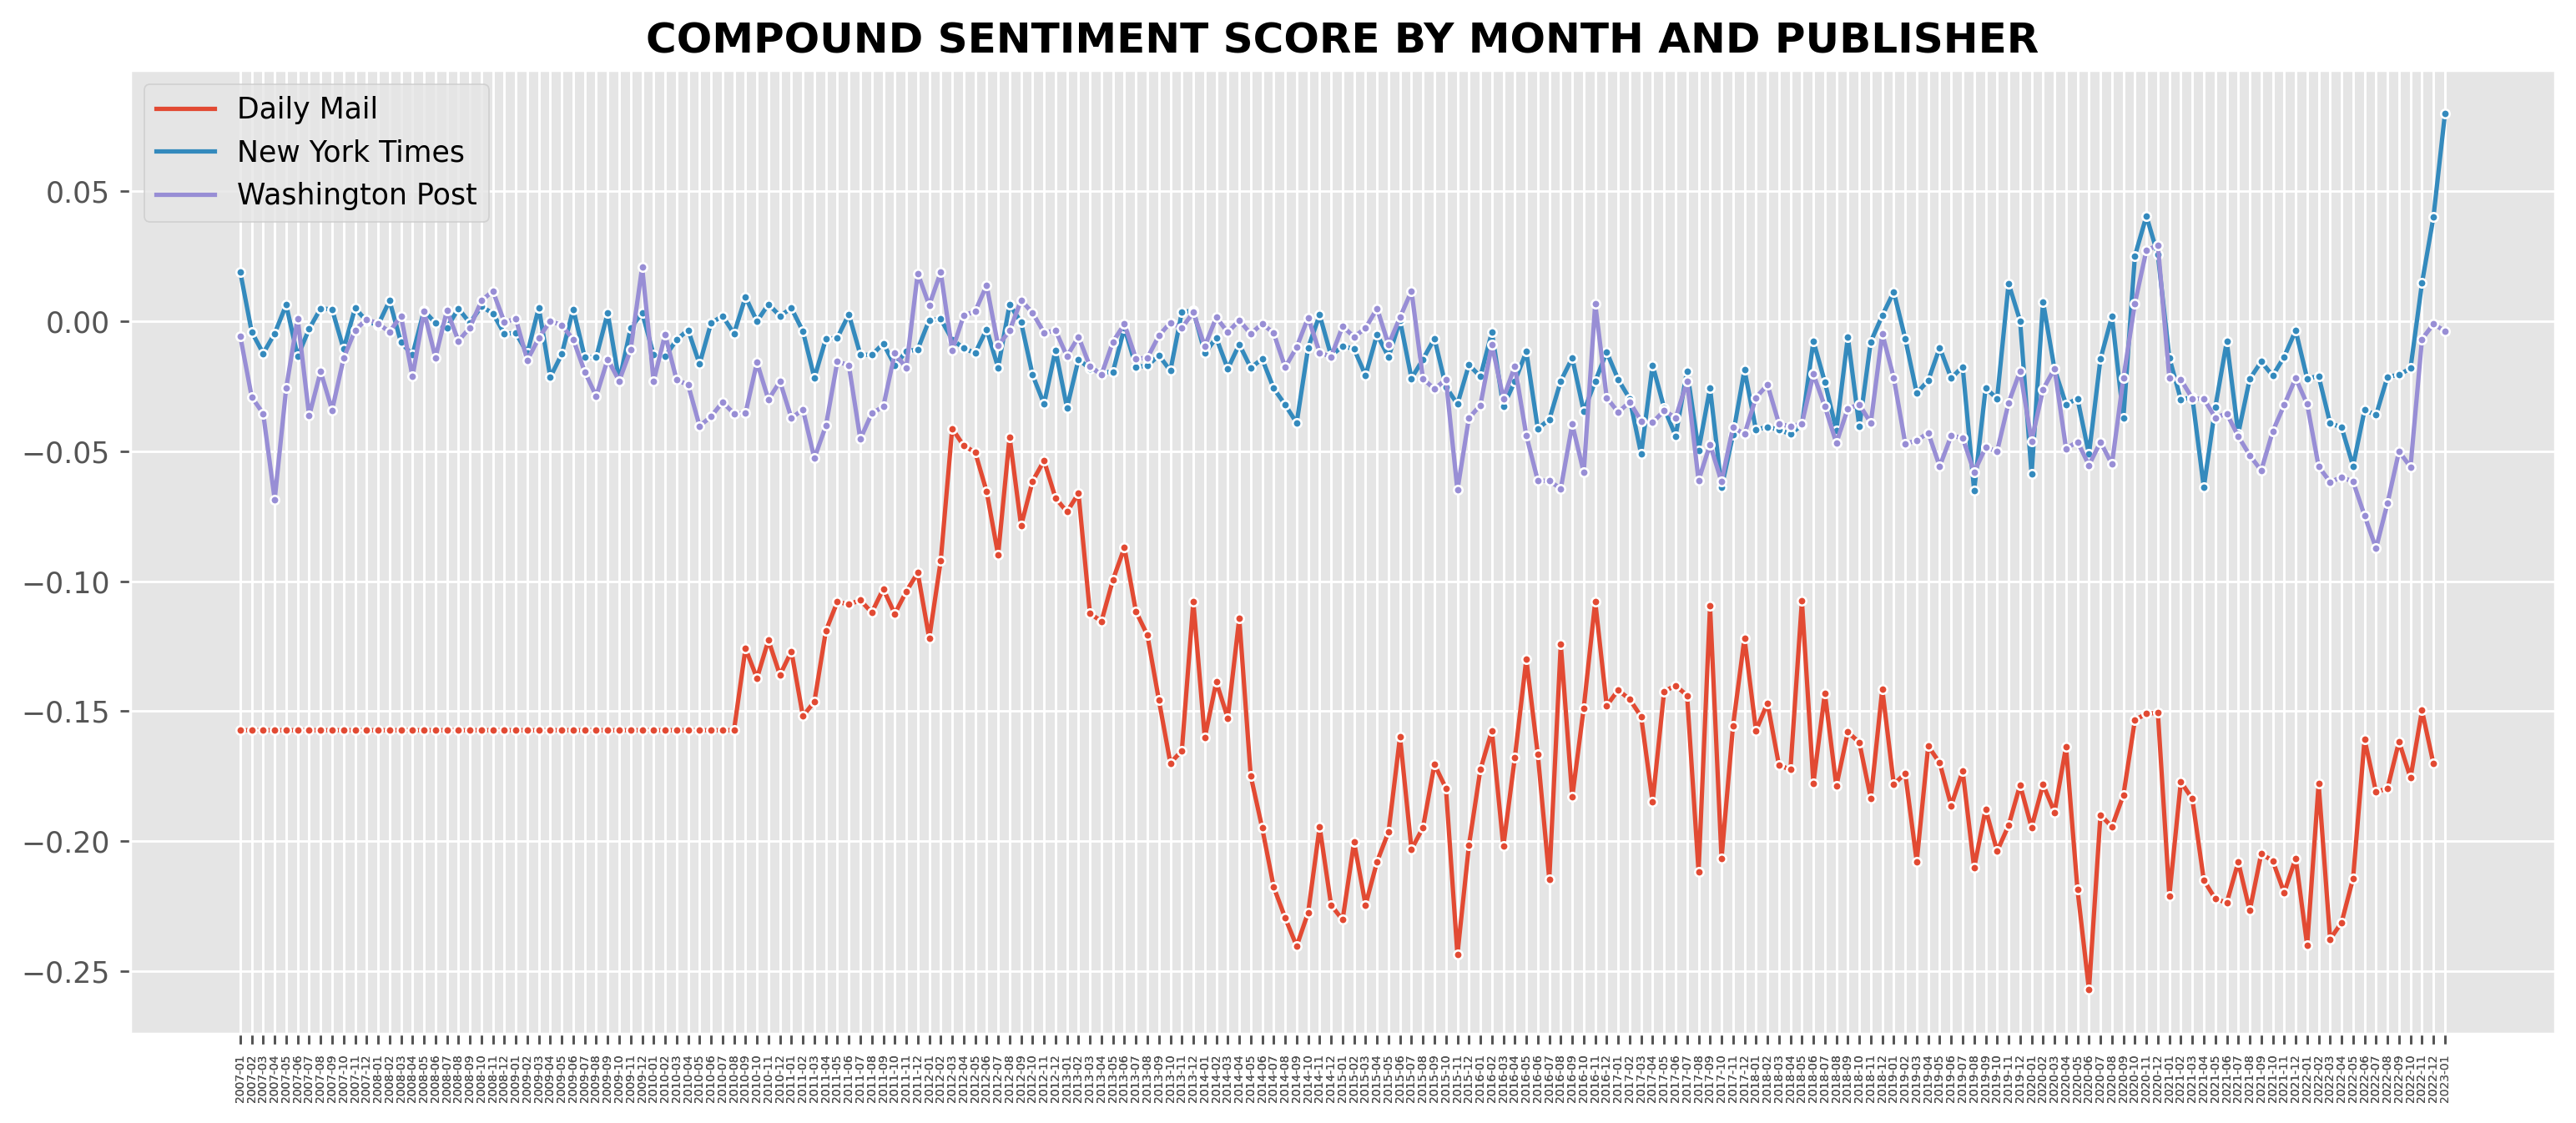

In [16]:
f=g[[i[1] in ['New York Times','Washington Post','Daily Mail'] for i in g.index]]

plt.figure(figsize=(15,6),dpi=250)
sns.lineplot(x=[str(i[0]) for i in f.index],y=f.values,hue=[str(i[1]) for i in f.index],marker='.')
plt.title('COMPOUND SENTIMENT SCORE BY MONTH AND PUBLISHER',fontweight='bold')
plt.xticks([str(i[0]) for i in f.index],rotation=90,size=4)
plt.show()

#Sentiment scores for New York Times and Washington Post are correlated to each other.
# Daily Mail has publications with the lowest compound sentiment score. 

### Confidence Intervals - Find Which News Company Publishes Murder Related News Most Often

In [14]:
keywords = ['murder', 'murdered', 'killer', 'killed']

def find_words(x):
    matches = 0
    for w in x:
        if w.strip().lower() in keywords:
            matches += 1
    return matches

publication_dict = {}
for publication in df['Publication'].unique():

    sample = df.query('Publication == @publication').sample(10**4)
    sample['Words'] = sample['Headline'].str.split()

    total_cases = sample['Words'].apply(lambda x: find_words(x) if isinstance(x, list) else 0)
    publication_dict[publication] = {'Cases':total_cases.sum(),'Total':len(sample)}  # Sum up the keyword occurrences for each publication

publication_dict

{'New York Times': {'Cases': 48, 'Total': 10000},
 'CNN': {'Cases': 130, 'Total': 10000},
 'FOX': {'Cases': 246, 'Total': 10000},
 'Washington Post': {'Cases': 59, 'Total': 10000},
 'Daily Mail': {'Cases': 370, 'Total': 10000},
 'CNBC': {'Cases': 9, 'Total': 10000},
 'The Guardian': {'Cases': 125, 'Total': 10000},
 'BBC': {'Cases': 43, 'Total': 10000},
 'USA Today': {'Cases': 86, 'Total': 10000},
 'New York Post': {'Cases': 162, 'Total': 10000}}

In [15]:
for key,values in publication_dict.items():
    sample_size=values['Total']
    sample_cases=values['Cases']
    pupulation_size=df[df['Publication']==key].shape[0]
    
    # Proportion of successes in the sample
    p_hat = sample_cases / sample_size

    # Critical value for 95% confidence level
    Z = 1.96

    # Calculate the standard error of the proportion
    standard_error = math.sqrt((p_hat * (1 - p_hat)) / sample_size)

    # Calculate the margin of error for the confidence interval
    margin_of_error = Z * standard_error

    # Calculate the lower and upper bounds of the confidence interval
    lower_bound = f'{round(100*(p_hat - margin_of_error),2)} %'
    upper_bound = f'{round(100*(p_hat + margin_of_error),2)} %'

    print(f'For {key} With 95% CI, Percentage Of Murder Related Publications Will Be Between {lower_bound} And {upper_bound}')

For New York Times With 95% CI, Percentage Of Murder Related Publications Will Be Between 0.34 % And 0.62 %
For CNN With 95% CI, Percentage Of Murder Related Publications Will Be Between 1.08 % And 1.52 %
For FOX With 95% CI, Percentage Of Murder Related Publications Will Be Between 2.16 % And 2.76 %
For Washington Post With 95% CI, Percentage Of Murder Related Publications Will Be Between 0.44 % And 0.74 %
For Daily Mail With 95% CI, Percentage Of Murder Related Publications Will Be Between 3.33 % And 4.07 %
For CNBC With 95% CI, Percentage Of Murder Related Publications Will Be Between 0.03 % And 0.15 %
For The Guardian With 95% CI, Percentage Of Murder Related Publications Will Be Between 1.03 % And 1.47 %
For BBC With 95% CI, Percentage Of Murder Related Publications Will Be Between 0.3 % And 0.56 %
For USA Today With 95% CI, Percentage Of Murder Related Publications Will Be Between 0.68 % And 1.04 %
For New York Post With 95% CI, Percentage Of Murder Related Publications Will Be B